# Set up

In [24]:
!pip install ta
!pip install tensorflow
!pip install scikit-learn
!pip install scikeras
!pip install seaborn

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import ta
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import time
import re
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# Preparing Data

In [26]:
class DataSet:
    def __init__(self, sym, start_date, end_date, num_steps, test_ratio, normalized=True):
        self.sym = sym
        self.start_date = start_date
        self.end_date = end_date
        self.num_steps = num_steps
        self.test_ratio = test_ratio
        self.normalized = normalized
        self.data = self.download_data()
        self.train_X, self.train_y, self.val_X, self.val_y, self.test_X, self.test_y = self.prepare_data()
        self.test_y_max, self.test_y_min = self.get_maxmin()

    def info(self):
        return "StockDataSet [%s] train: %d test: %d" % (self.sym, len(self.train_X), len(self.test_y))

    def download_data(self):
        # Download data from yahoo!finance
        raw_df = yf.download(self.sym, start=self.start_date, end=self.end_date)

        #Feature1: 10 days average returns
        raw_df['avg_ret_10'] = (raw_df['Adj Close'].shift(-10) - raw_df['Adj Close']) / raw_df['Adj Close']

        #Feature2:sharpe ratio
        annual_risk_free_rate = 0.045
        daily_returns = raw_df['Adj Close'].pct_change()
        daily_risk_free_rate = (1 + annual_risk_free_rate) ** (10/252) - 1 
        rolling_sharpe_ratio = (raw_df['avg_ret_10'] - daily_risk_free_rate) / raw_df['avg_ret_10'].std()
        
        # annualized rolling sharpe ratio
        annualized_rolling_sharpe_ratio = rolling_sharpe_ratio * (252 / 10) ** 0.5
        raw_df['10_Day_Rolling_Sharpe_Ratio'] = annualized_rolling_sharpe_ratio
        raw_df = raw_df.apply(lambda x: x.fillna(x.mean()), axis=0)

        return raw_df

    def get_maxmin(self):
      test_y_max = self.data['Close'].max()
      test_y_min = self.data['Close'].min()

      return test_y_max, test_y_min

    def prepare_data(self):
        features = ['Open', 'High', 'Low', 'Close', 'Volume','avg_ret_10','10_Day_Rolling_Sharpe_Ratio' ]
        data = self.data[features].values

        if self.normalized:
            scaler = MinMaxScaler(feature_range=(0, 1))
            data = scaler.fit_transform(data)

        # Prepare sequences
        X, y = [], []
        for i in range(len(data) - self.num_steps):
            X.append(data[i: i + self.num_steps])
            y.append(data[i + self.num_steps, features.index('Close')])

        X, y = np.array(X), np.array(y)

        # Split into training and test sets
        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X = X[:train_size]
        train_y = y[:train_size]

        # Split into Validation sets from test sets
        midpoint_X = int(len(X[train_size:]) // 2) + train_size
        midpoint_y = int(len(y[train_size:]) // 2) + train_size
        val_X, test_X = X[train_size:midpoint_X], X[midpoint_X:]
        val_y, test_y = y[train_size:midpoint_y], y[midpoint_y:]

        return train_X, train_y, val_X, val_y, test_X, test_y

    def generate_one_epoch(self, batch_size):
        num_batches = int(len(self.train_X)) // batch_size
        if batch_size * num_batches < len(self.train_X):
            num_batches += 1

        batch_indices = list(range(num_batches))
        random.shuffle(batch_indices)
        for j in batch_indices:
            batch_X = self.train_X[j * batch_size: (j + 1) * batch_size]
            batch_y = self.train_y[j * batch_size: (j + 1) * batch_size]
            yield batch_X, batch_y


# Constructing Model

In [27]:
def lstm_model(num_layers, units_per_layer, dropout_rate, input_shape, **kwargs):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(units_per_layer, input_shape=input_shape, return_sequences=True if num_layers > 1 else False))
        elif i == num_layers - 1:
            model.add(LSTM(units_per_layer, return_sequences=False))
        else:
            model.add(LSTM(units_per_layer, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Parameters Space

In [28]:
# Defining Asset
sym = 'SPY'
start_date = datetime(2013, 1, 1)
end_date = datetime(2023, 12, 31)

# Fixed Parameters
test_ratio = 0.4
batch_size = 32
n_epochs = 50
num_steps = 20

# Getting Data
ds = DataSet(sym, start_date, end_date, num_steps, test_ratio, normalized=True)
train_X, train_y, val_X, val_y, test_X, test_y = ds.prepare_data()
test_y_max, test_y_min = ds.get_maxmin()

[*********************100%%**********************]  1 of 1 completed


In [29]:
# Prarmeters Space
param_grid = {
    'model__num_layers': [2, 3, 4],
    'model__units_per_layer': [50, 128, 256],
    'model__dropout_rate':[0.1, 0.2, 0.3],
    'model__input_shape': [(train_X.shape[1], train_X.shape[2])]
}
model = KerasRegressor(build_fn=lstm_model , verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size)

# Find the best model and predict
best_model = grid.best_estimator_.model_
val_y_pred = best_model.predict(val_X)

# Calculate loss on validation data
val_loss = np.mean((val_y - val_y_pred)**2)
print(f"Validation MSE: {val_loss}")

# Best parameters
print("Best parameters found: ", grid.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning:

[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time=  48.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time=  51.7s
[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time=  51.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserW

[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 2.1min
[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserW

[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 4.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 6.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=256; total time= 7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=256; total time= 7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.1, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=256; total time= 7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=50; total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 6.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=128; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 3.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 7.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 4.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=256; total time= 7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=256; total time= 7.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=50; total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.2, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=256; total time= 7.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=2, model__units_per_layer=256; total time= 4.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=50; total time= 2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.7min
[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=128; total time= 4.2min
[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 5.0min
[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 5.4min
[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=3, model__units_per_layer=256; total time= 5.5min
[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 5.4min
[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=4, model__units_per_layer=128; total time= 5.2min
[CV] END model__dropout_rate=0.3, model__input_shape=(20, 7), model__num_layers=4, model__

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Validation MSE: 0.05104047851839472
Best parameters found:  {'model__dropout_rate': 0.1, 'model__input_shape': (20, 7), 'model__num_layers': 3, 'model__units_per_layer': 128}


# Training Process

In [38]:
best_model = lstm_model(num_layers = 3, units_per_layer = 128, dropout_rate = 0.1, input_shape = (20, 7))
history = best_model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y))

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0146 - val_loss: 0.0117
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.1552e-04 - val_loss: 0.0121
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.6450e-04 - val_loss: 0.0072
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.1692e-04 - val_loss: 0.0088
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.5447e-04 - val_loss: 0.0079
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.3286e-04 - val_loss: 0.0012
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.3386e-04 - val_loss: 0.0027
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.5111e-04 - val_loss: 0.0040
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.5198e-04 - val_loss: 0.0053
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.1532e-04 - val_loss: 0.0011
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.9711e-04 - val_loss: 0.0029
Epoch 12/50
52/52 ━━━━━

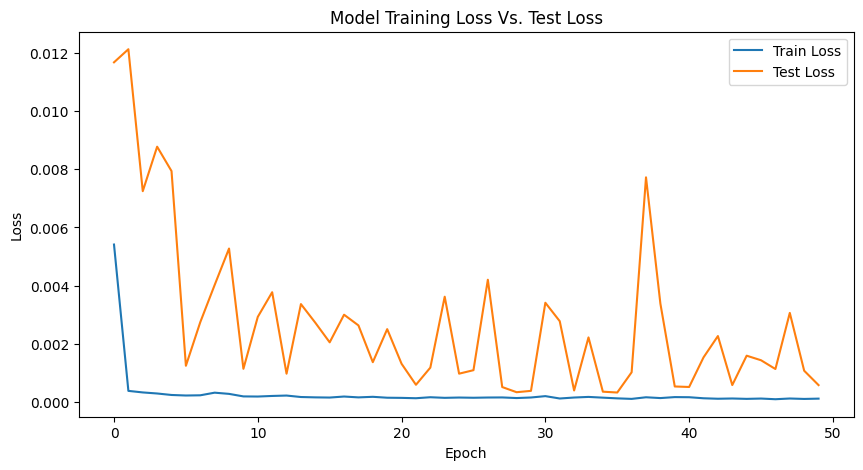

In [39]:
# Plotting the training and test loss
plt.figure(figsize=(10, 5))  # Keep the figure size as is or adjust to your preference
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')  # Assuming val_loss is your test loss here
plt.title('Model Training Loss Vs. Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Assuming lstm is your trained model and X_test is your test dataset
predictions = best_model.predict(test_X)#(lstm.model.predict(test_X) > 0.5).astype(int)
predicted_prices = predictions*(test_y_max - test_y_min) + test_y_min
actual_prices = test_y*(test_y_max - test_y_min) + test_y_min

print(actual_prices)
print(predicted_prices)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[453.11999512 455.54998779 455.95999146 453.94000244 458.32000732
 459.25       460.04000854 461.8999939  464.72000122 466.91000366
 468.52999878 468.92999268 467.38000488 463.61999512 463.76998901
 467.26998901 467.42999268 469.27999878 468.14001465 469.73001099
 468.89001465 467.57000732 468.19000244 469.44000244 458.97000122
 464.6000061  455.55999756 450.5        457.3999939  453.42001343
 458.79000854 468.27999878 469.51998901 466.3500061  470.73999023
 466.57000732 463.35998535 470.6000061  466.45001221 459.86999512
 454.98001099 463.05999756 467.69000244 470.6000061  477.26000977
 476.86999512 477.48001099 476.16000366 474.95999146 477.70999146
 477.54998779 468.38000488 467.94000244 466.08999634 465.51000977
 469.75       471.01998901 464.52999878 464.72000122 456.48999023
 451.75       446.75       437.98001099 439.83999634 434.47000122
 433.38000488 431.23999023 441.95001221 449.91000366 452.95001221
 457.3500061  446.6000061  448.70001

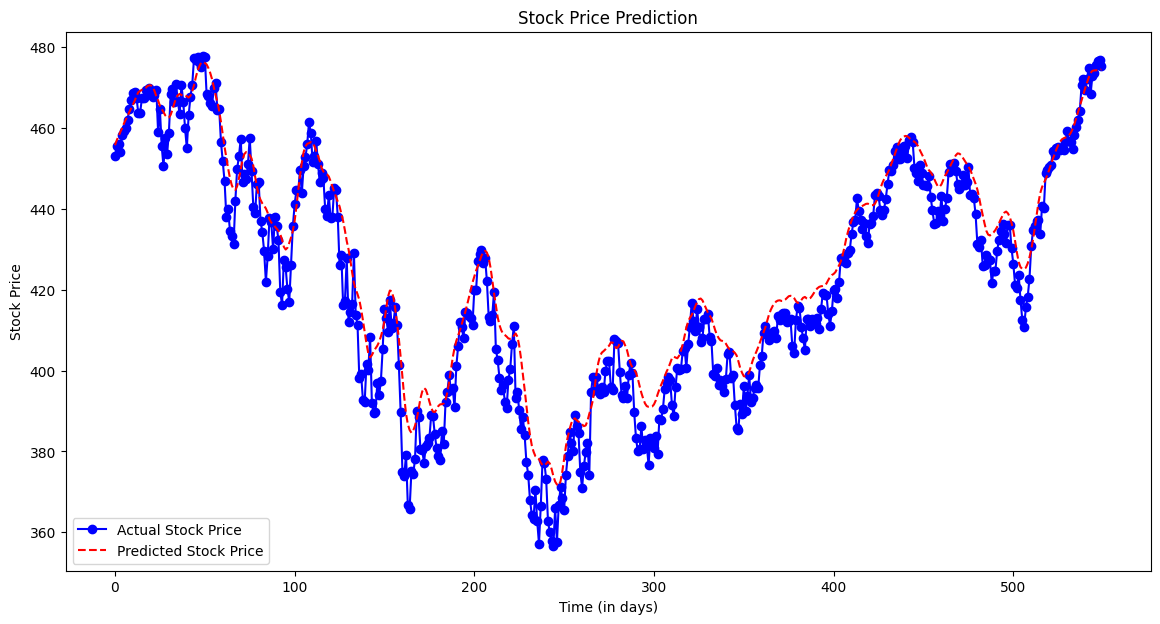

In [41]:
# Plot actual vs predicted stock prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', marker='o', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', linestyle='--', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time (in days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Trading Signals

In [42]:
# Initialize the signal array
trading_signals = np.zeros_like(predicted_prices)

# Generate signals
for i in range(1, len(predicted_prices)):
    if predicted_prices[i] > actual_prices[i-1]:
        trading_signals[i] = 1
    else:
        trading_signals[i] = -1

# Print results
print("Trading Signals: ", trading_signals)  # Skip the first signal as there's no previous day actual price for the first prediction

Trading Signals:  [[ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [

# Backtesting Report

In [45]:
# Convert actual_prices to a Pandas Series
prices_series = pd.Series(actual_prices)

# Calculate daily returns using the shift method in Pandas
daily_returns = prices_series.pct_change().fillna(0)  # replace NaN in the first day with 0

# Flatten the array to make it 1D
trading_signals = trading_signals.flatten()

# Strategy returns
strategy_returns = trading_signals * daily_returns  # Element-wise multiplication

# Convert to pandas Series for further analysis
strategy_returns_series = pd.Series(strategy_returns)

# Calculate cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod() - 1

# Assuming the data covers one year (252 trading days)
final_cumulative_return = cumulative_returns.iloc[-1]
annual_return = (1 + final_cumulative_return) ** (252 / len(daily_returns)) - 1

# Annualized Sharpe Ratio (assuming 252 trading days per year)
sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)

# Calculate drawdown
cumulative_wealth = (1 + strategy_returns).cumprod()
peak_wealth = cumulative_wealth.cummax()
drawdown = (cumulative_wealth - peak_wealth) / peak_wealth
max_drawdown = drawdown.min()

# Annualized volatility
annual_volatility = strategy_returns.std() * np.sqrt(252)

# Calculating Skew and Kurtosis
skew = strategy_returns.skew()
kurtosis = strategy_returns.kurtosis()

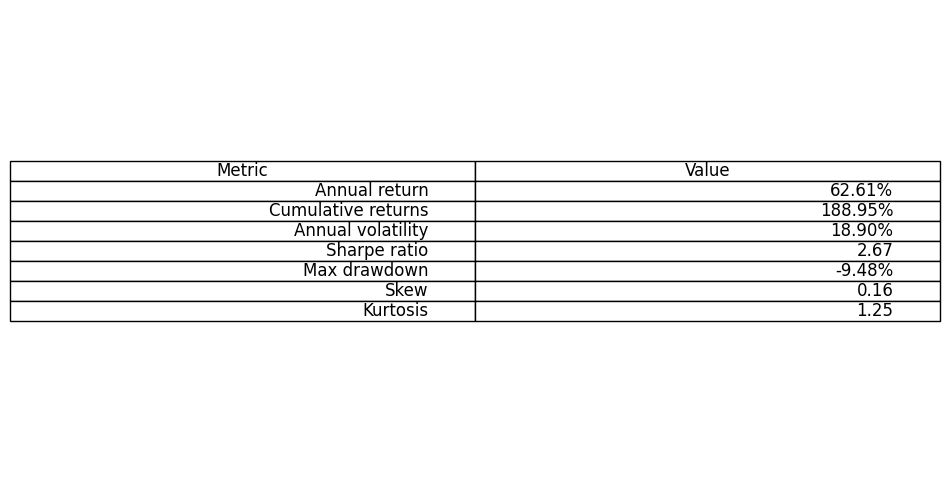

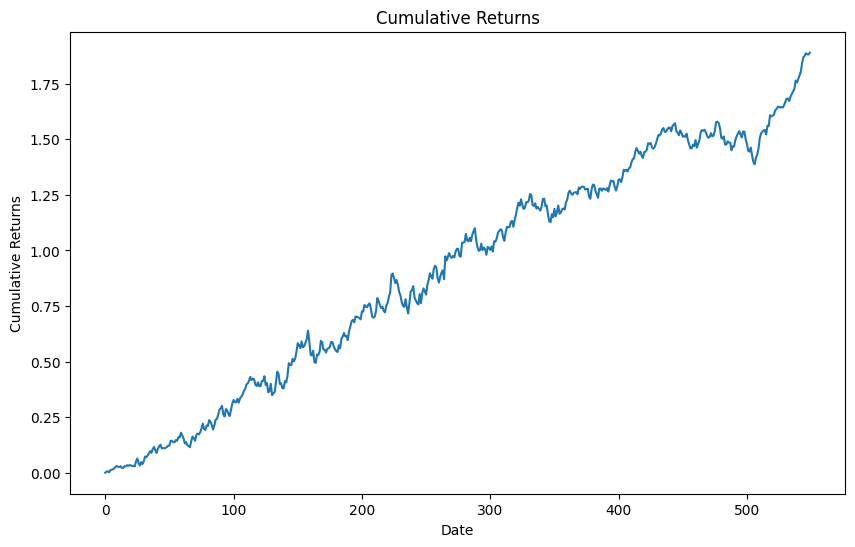

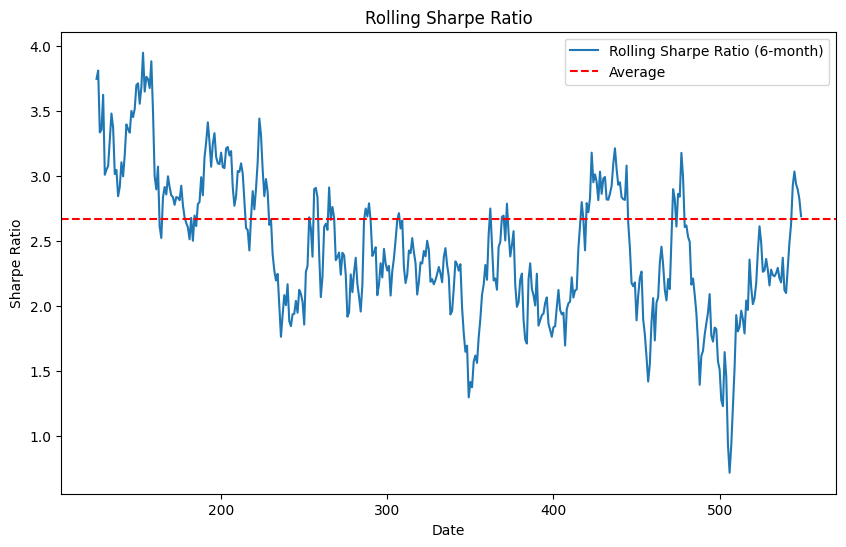

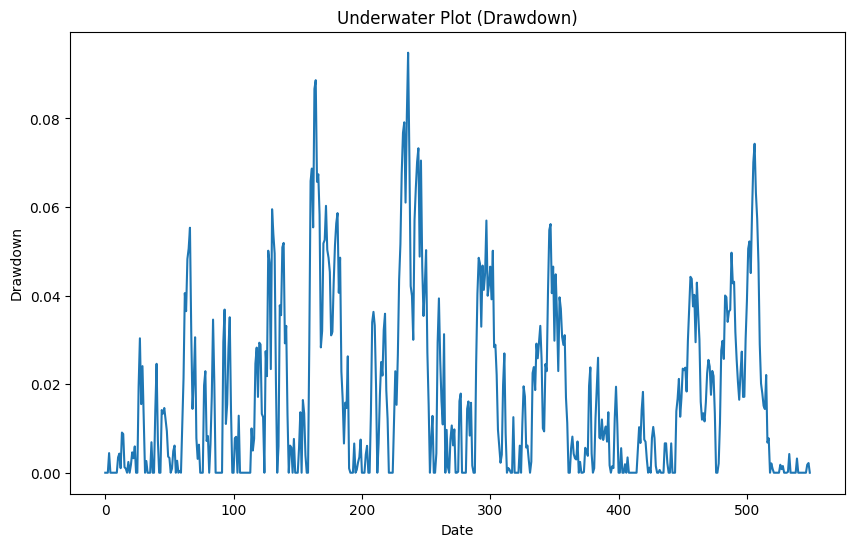

In [46]:
# Creating a dictionary with all metrics
metrics = {
    "Metric": [
        "Annual return", "Cumulative returns", "Annual volatility",
        "Sharpe ratio", "Max drawdown", "Skew", "Kurtosis"
    ],
    "Value": [
        f"{annual_return * 100:.2f}%",  # Annual return
        f"{cumulative_returns.iloc[-1] * 100:.2f}%",  # Cumulative returns at the end of the period
        f"{annual_volatility * 100:.2f}%",
        f"{sharpe_ratio:.2f}",
        f"{max_drawdown * 100:.2f}%",
        f"{skew:.2f}",
        f"{kurtosis:.2f}"
    ]
}

# Convert dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame as a table using matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=strategy_returns.rolling(window=126).mean() / strategy_returns.rolling(window=126).std() * np.sqrt(252), label='Rolling Sharpe Ratio (6-month)')
plt.axhline(y=sharpe_ratio, color='r', linestyle='--', label='Average')
plt.title('Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
(-drawdown).plot()
plt.title('Underwater Plot (Drawdown)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()

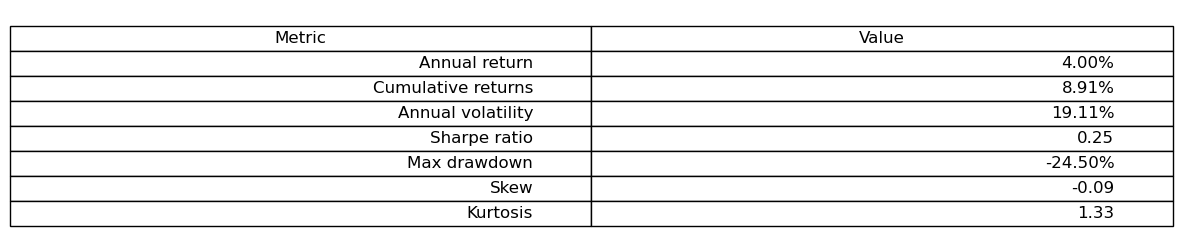

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Retrieve SPY index return
end_date = '2023-12-29'
spy = yf.Ticker("SPY")
spy_data = spy.history(period='max', end=end_date)

# Limit to the last 549 trading days
prices_series = spy_data['Close'].tail(549)

# Calculate daily returns
daily_returns = prices_series.pct_change().fillna(0)

# Annual return
cumulative_returns = (1 + daily_returns).cumprod() - 1
final_cumulative_return = cumulative_returns.iloc[-1]
annual_return = (1 + final_cumulative_return) ** (252 / len(daily_returns)) - 1

# Annualized volatility
annual_volatility = daily_returns.std() * np.sqrt(252)

# Sharpe ratio
risk_free_rate = 0.01 / 252  # Example: 1% annual risk-free rate
sharpe_ratio = (daily_returns.mean() - risk_free_rate) / daily_returns.std() * np.sqrt(252)

# Maximum drawdown
cumulative_wealth = (1 + daily_returns).cumprod()
peak_wealth = cumulative_wealth.cummax()
drawdown = (cumulative_wealth - peak_wealth) / peak_wealth
max_drawdown = drawdown.min()

# Skew and Kurtosis
skew = daily_returns.skew()
kurtosis = daily_returns.kurtosis()

# Creating a dictionary with all metrics
metrics = {
    "Metric": [
        "Annual return", "Cumulative returns", "Annual volatility",
        "Sharpe ratio", "Max drawdown", "Skew", "Kurtosis"
    ],
    "Value": [
        f"{annual_return * 100:.2f}%",  # Annual return
        f"{final_cumulative_return * 100:.2f}%",  # Cumulative returns
        f"{annual_volatility * 100:.2f}%",  # Annual volatility
        f"{sharpe_ratio:.2f}",  # Sharpe ratio
        f"{max_drawdown * 100:.2f}%",  # Max drawdown
        f"{skew:.2f}",  # Skew
        f"{kurtosis:.2f}"  # Kurtosis
    ]
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame as a table using Matplotlib
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)
plt.show()


To validate the performance of our LSTM model, we compared it against:

- **ARIMA (5,1,0)**: A univariate time-series forecasting model using historical returns.
- **Random Forest Regressor**: A tree-based ensemble model using technical and price features.

Both models were evaluated on the same test set using Mean Squared Error (MSE). As expected, the LSTM model outperformed traditional approaches due to its ability to capture temporal dependencies in multivariate data.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

returns = dataset.data['Adj Close'].pct_change().dropna()

train_size = int(len(returns) * 0.8)
train_returns, test_returns = returns[:train_size], returns[train_size:]

model_arima = ARIMA(train_returns, order=(5,1,0))
model_arima_fit = model_arima.fit()

forecast = model_arima_fit.forecast(steps=len(test_returns))
mse_arima = mean_squared_error(test_returns, forecast)

print("ARIMA MSE:", mse_arima)

plt.figure(figsize=(12,6))
plt.plot(test_returns.index, test_returns, label='Actual Returns')
plt.plot(test_returns.index, forecast, label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual Returns')
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

df = dataset.data.dropna()
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'avg_ret_10', 'sharpe']  # 可调整
features = df[feature_cols].drop('avg_ret_10', axis=1)
target = df['avg_ret_10']

split_idx = int(len(features) * (1 - dataset.test_ratio))
X_train_rf, y_train_rf = features[:split_idx], target[:split_idx]
X_test_rf, y_test_rf = features[split_idx:], target[split_idx:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)

print("Random Forest MSE:", mse_rf)

plt.figure(figsize=(12,6))
plt.plot(y_test_rf.values, label='Actual')
plt.plot(y_pred_rf, label='RF Predicted')
plt.title('Random Forest Prediction vs Actual')
plt.legend()
plt.show()
